# 比較氣象資料的預測值與觀測值

專案本身是經由氣象預報資料預測氣象觀測資料，再由氣象觀測資料預測電力資料，這份筆記本的目的是驗證現行主力模型對於氣象觀測資料的預測成績。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#這兩行讓 matplotlib 的圖可以顯示中文，同時正常顯示負號
matplotlib.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False
import datetime

from utils.station_info import town_and_station

In [2]:
data_path = './historical/data/'

In [3]:
selected_stations = ['臺北', '高雄', '嘉義', '東吉島', '臺中電廠', '通霄漁港', '福寶']

## 讀取並整理氣象預報、模型預測以及實際觀測的資料

### forecast_interpret 函式

forecast_interpret 這個函式利用直觀方法將原始的每三個小時一次的紀錄轉換成全天的紀錄  
比如某天高雄市楠梓區有 0 點到 21 點共八筆溫度預報資料，函式的直觀方法將取八筆的最高值為當天最高氣溫預報值，最低值為最低氣溫預報值，平均值為氣溫預報值

In [4]:
def forecast_interpret(forecast_df, first_date):
    def get_related_columns(columns, feature):
        feature_str = feature
        if '氣溫' in feature:
            feature_str = '溫度'
        result = []
        for col in columns:
            if col.split('_')[0] == feature_str:
                result.append(col)
        return result
        
    interpretation_dict = {
        '日期': [],
        '站名': [],
        '氣溫': [],
        '最低氣溫': [],
        '最高氣溫': [],
        '風速': [],
    }

    feature_list = list(interpretation_dict.keys())
    feature_list.remove('日期')
    feature_list.remove('站名')

    forecast_df = forecast_df[forecast_df['日期']>=first_date]
    
    for i in forecast_df.index:
        this_series = forecast_df.loc[i]
        interpretation_dict['日期'].append(this_series['日期'])
        interpretation_dict['站名'].append(town_and_station[this_series['鄉鎮']])
        for feature in feature_list:
            this_f_series = this_series[get_related_columns(forecast_df.columns, feature)]
            try:
                if feature in ['氣溫', '風速']:
                    this_val = np.nanmean(list(this_f_series))
                elif feature == '最高氣溫':
                    this_val = np.nanmax(list(this_f_series))
                elif feature == '最低氣溫':
                    this_val = np.nanmin(list(this_f_series))
            except:
                this_val = np.nan
            interpretation_dict[feature].append(this_val)
    return pd.DataFrame(interpretation_dict)

### Extract and Transform

In [5]:
def select_station(df, selected_stations):
    df_list = []
    for station in selected_stations:
        df_list.append(df[df['站名']==station])
    return pd.concat(df_list, axis=0, ignore_index=True)

In [6]:
w_pred_df = pd.read_csv(f'{data_path}prediction/weather.csv')
w_obs_df = pd.read_csv(f'{data_path}weather/finalized/big_table.csv')
w_forecast_df = pd.read_csv(f'{data_path}weather/finalized/weather_forecast.csv')

w_pred_df['日期'] = pd.to_datetime(w_pred_df['日期'])

w_obs_df['日期'] = pd.to_datetime(w_obs_df['日期'])
w_obs_df.sort_values('日期', inplace=True)
w_obs_df.reset_index(drop=True, inplace=True)
col_map = {col: col.split('(')[0] for col in w_obs_df.columns}
w_obs_df.rename(col_map, axis=1, inplace=True)
w_obs_df = w_obs_df[w_pred_df.columns]

w_forecast_df['日期'] = pd.to_datetime(w_forecast_df['日期'])

w_forecast_interp_df = forecast_interpret(w_forecast_df, first_date=min(w_pred_df['日期']))

In [7]:
w_obs_df = select_station(w_obs_df, selected_stations)

In [8]:
display(w_forecast_df.tail(10))
display(w_pred_df.tail(10))
display(w_obs_df.tail(10))
display(w_forecast_interp_df.tail(10))

,鄉鎮,日期,晴_0,多雲_0,陰_0,短暫陣雨_0,短暫陣雨或雷雨_0,午後短暫雷陣雨_0,陣雨或雷雨_0,溫度_0,...,陰_21,短暫陣雨_21,短暫陣雨或雷雨_21,午後短暫雷陣雨_21,陣雨或雷雨_21,溫度_21,降水機率_21,相對溼度_21,風速_21,風向_21
593,彰化縣福興鄉,2024-09-30,1,0,0,0,0,0,0,28,...,0,0,0,0,0,29,0.0,88,3,180
594,彰化縣福興鄉,2024-10-01,1,0,0,0,0,0,0,29,...,0,1,0,0,0,29,0.3,82,11,360
595,彰化縣福興鄉,2024-10-02,0,0,1,0,0,0,0,29,...,0,0,1,0,0,26,0.7,85,11,360
596,彰化縣福興鄉,2024-10-03,0,0,0,0,1,0,0,26,...,1,0,0,0,0,25,0.4,80,11,360
597,彰化縣福興鄉,2024-10-04,0,0,0,1,0,0,0,25,...,0,0,0,0,0,25,0.2,92,2,45
598,彰化縣福興鄉,2024-10-05,0,1,0,0,0,0,0,26,...,0,0,0,0,0,27,0.2,88,1,90
599,彰化縣福興鄉,2024-10-06,1,0,0,0,0,0,0,26,...,0,0,0,0,0,27,0.1,91,1,180
600,彰化縣福興鄉,2024-10-07,1,0,0,0,0,0,0,26,...,0,0,0,0,0,27,0.2,87,2,45
601,彰化縣福興鄉,2024-10-08,0,1,0,0,0,0,0,26,...,0,0,0,0,0,26,0.1,78,4,45
602,彰化縣福興鄉,2024-10-09,1,0,0,0,0,0,0,25,...,0,0,0,0,0,25,0.1,73,3,45


,日期,站名,日照率,最低氣溫,最高氣溫,氣溫,風速,午後平均氣溫,下午平均氣溫,傍晚平均氣溫,午後平均風速,下午平均風速,傍晚平均風速,全天空日射量
462,2024-10-08,臺北,51.186267,24.979436,28.824144,26.259016,1.853626,26.346544,25.922092,26.243018,2.984357,2.684870,1.465368,18.067398
463,2024-10-08,高雄,66.609030,25.179320,30.761866,27.641064,1.406536,29.676625,27.864005,27.445360,3.014990,2.806243,1.548265,21.055334
464,2024-10-09,福寶,80.948018,24.972346,30.256990,27.178589,3.985110,29.026586,27.600223,27.151804,3.450800,3.453604,2.664997,23.572184
465,2024-10-09,通霄漁港,77.662473,24.655117,28.884825,26.182543,4.193623,26.843510,25.896305,26.090649,4.113413,3.651030,2.672702,22.928002
466,2024-10-09,臺西,81.403319,25.037796,29.872314,26.928305,3.806059,28.137651,26.848221,26.872346,3.548880,3.727390,2.839403,23.686721
467,2024-10-09,臺中電廠,82.799742,24.765597,29.786198,26.697017,4.006457,28.214119,26.626982,26.510925,3.479987,3.722125,2.931787,23.896769
468,2024-10-09,東吉島,79.985577,24.990041,28.911848,26.343712,6.846324,26.453811,26.142330,26.376092,5.403384,3.835569,5.410218,23.464077
469,2024-10-09,嘉義,76.491562,24.843411,30.826113,27.044546,1.414649,29.712763,27.867921,27.056696,2.510862,2.427723,1.476970,22.798118
470,2024-10-09,高雄,80.618572,24.890000,30.756325,27.337016,1.306383,29.287632,27.382638,27.235709,2.777867,2.714611,1.552052,23.624291
471,2024-10-09,臺北,43.473858,24.721857,28.530905,26.059915,2.263495,25.676438,25.475310,25.997027,2.916504,2.836711,1.597004,16.633842


,日期,站名,日照率,最低氣溫,最高氣溫,氣溫,風速,午後平均氣溫,下午平均氣溫,傍晚平均氣溫,午後平均風速,下午平均風速,傍晚平均風速,全天空日射量
4519,2024-09-29,福寶,NaN,25.4,31.5,28.5,3.1,30.3,31.2,29.7,4.9,2.1,3.1,NaN
4520,2024-09-30,福寶,NaN,26.4,32.6,29.4,2.7,31.1,31.6,29.9,3.3,2.5,2.4,NaN
4521,2024-10-01,福寶,NaN,27.6,30.9,28.9,3.2,30.2,29.0,28.5,6.0,2.2,2.5,NaN
4522,2024-10-02,福寶,NaN,25.8,27.4,26.7,15.9,26.8,26.1,25.8,17.9,20.9,22.6,NaN
4523,2024-10-03,福寶,NaN,24.9,25.9,25.4,19.4,25.6,25.7,24.9,20.2,19.6,20.6,NaN
4524,2024-10-04,福寶,NaN,23.9,25.8,24.7,11.3,25.3,25.2,25.0,12.3,11.9,9.3,NaN
4525,2024-10-05,福寶,NaN,25.0,26.8,25.8,7.1,26.7,26.6,26.3,8.3,8.2,6.5,NaN
4526,2024-10-06,福寶,NaN,26.0,29.1,27.3,2.9,28.2,28.3,27.4,4.5,5.7,4.0,NaN
4527,2024-10-07,福寶,NaN,25.7,30.2,27.4,5.3,28.2,28.2,27.0,6.5,8.3,8.8,NaN
4528,2024-10-08,福寶,NaN,24.1,27.3,25.9,9.7,26.9,26.1,24.8,13.2,13.3,12.7,NaN


,日期,站名,氣溫,最低氣溫,最高氣溫,風速
461,2024-09-30,福寶,30.000,27,34,2.625
462,2024-10-01,福寶,30.250,28,34,5.500
463,2024-10-02,福寶,28.250,26,30,10.875
464,2024-10-03,福寶,26.000,25,27,11.000
465,2024-10-04,福寶,25.750,25,27,4.750
466,2024-10-05,福寶,27.875,26,31,2.250
467,2024-10-06,福寶,27.875,26,31,1.750
468,2024-10-07,福寶,27.875,26,31,2.625
469,2024-10-08,福寶,27.250,26,30,4.875
470,2024-10-09,福寶,26.750,25,30,5.000


### 合併資料，並選出日期與站名的交集

In [9]:
w_pred_obs_df = pd.merge(w_pred_df, w_obs_df, on=['日期', '站名'], how='inner', suffixes=['_預測','_觀測'])
w_forecast_obs_df = pd.merge(w_forecast_interp_df, w_obs_df, on=['日期', '站名'], how='inner', suffixes=['_預報','_觀測'])
w_forecast_obs_df.drop(['全天空日射量', '日照率'],axis=1 , inplace=True)
display(w_pred_obs_df.tail(15))
display(w_forecast_obs_df.tail(15))

,日期,站名,日照率_預測,最低氣溫_預測,最高氣溫_預測,氣溫_預測,風速_預測,午後平均氣溫_預測,下午平均氣溫_預測,傍晚平均氣溫_預測,...,最高氣溫_觀測,氣溫_觀測,風速_觀測,午後平均氣溫_觀測,下午平均氣溫_觀測,傍晚平均氣溫_觀測,午後平均風速_觀測,下午平均風速_觀測,傍晚平均風速_觀測,全天空日射量_觀測
380,2024-10-06,嘉義,61.505027,25.174004,31.070406,27.504733,1.944869,30.279721,28.550247,27.636951,...,31.9,27.6,1.3,31.1,29.6,26.7,1.9,2.2,1.7,19.57
381,2024-10-07,臺中電廠,73.186863,25.037669,30.225996,27.170069,2.426075,28.776833,27.316362,27.115259,...,29.5,27.7,2.7,29.4,29.0,27.5,3.9,3.7,3.6,NaN
382,2024-10-07,東吉島,55.720109,25.289683,29.720930,27.220254,4.181740,27.638362,26.989233,26.991240,...,29.2,27.2,5.1,28.8,28.2,26.7,2.9,5.2,8.9,19.43
383,2024-10-07,嘉義,56.427019,25.021066,30.910732,27.249777,1.622404,29.882435,28.104973,27.283219,...,33.1,27.5,1.6,32.7,28.0,25.9,2.3,3.7,1.2,20.05
384,2024-10-07,福寶,70.983430,25.275627,30.891420,27.862762,2.545815,29.783048,28.634625,27.661428,...,30.2,27.4,5.3,28.2,28.2,27.0,6.5,8.3,8.8,NaN
385,2024-10-07,臺北,51.858881,25.074570,30.100031,27.236875,1.756988,28.624264,27.096124,26.982185,...,29.9,26.8,2.8,27.9,26.4,25.2,3.0,2.7,2.6,14.79
386,2024-10-07,通霄漁港,72.918241,25.076624,29.818403,26.930530,3.034560,28.027621,27.006471,26.881396,...,28.3,26.4,1.9,27.9,27.4,26.2,4.1,3.3,2.5,NaN
387,2024-10-07,高雄,40.100149,25.019604,30.567554,27.559675,1.255752,29.469720,27.384595,27.309045,...,31.8,27.5,1.2,31.0,29.4,27.4,3.0,2.5,1.0,24.19
388,2024-10-08,嘉義,66.169390,24.940729,30.672413,27.164607,1.431195,29.431168,27.655375,27.029745,...,31.5,26.9,1.6,31.0,29.5,26.0,1.7,3.5,2.2,21.61
389,2024-10-08,東吉島,71.446766,25.091697,29.057791,26.408242,8.190770,26.910197,26.358511,26.554126,...,27.8,26.4,11.1,27.5,26.6,25.7,10.8,12.4,12.8,19.57


,日期,站名,氣溫_預報,最低氣溫_預報,最高氣溫_預報,風速_預報,最低氣溫_觀測,最高氣溫_觀測,氣溫_觀測,風速_觀測,午後平均氣溫,下午平均氣溫,傍晚平均氣溫,午後平均風速,下午平均風速,傍晚平均風速
379,2024-09-24,福寶,28.750,26,32,3.000,26.1,30.2,28.3,3.0,30.0,29.4,28.7,4.0,4.2,3.3
380,2024-09-25,福寶,28.750,26,32,1.750,26.5,29.8,28.3,2.2,29.5,28.9,28.4,4.6,3.4,2.0
381,2024-09-26,福寶,28.500,26,32,2.000,27.4,29.6,28.6,3.1,29.3,NaN,NaN,7.2,NaN,NaN
382,2024-09-27,福寶,28.625,26,32,2.375,27.2,29.0,28.2,5.5,28.9,28.7,28.2,6.9,8.2,7.6
383,2024-09-28,福寶,28.875,26,32,4.500,26.3,29.7,28.0,9.6,29.4,29.3,28.5,14.5,13.8,13.0
384,2024-09-29,福寶,29.375,26,33,2.625,25.4,31.5,28.5,3.1,30.3,31.2,29.7,4.9,2.1,3.1
385,2024-09-30,福寶,30.000,27,34,2.625,26.4,32.6,29.4,2.7,31.1,31.6,29.9,3.3,2.5,2.4
386,2024-10-01,福寶,30.250,28,34,5.500,27.6,30.9,28.9,3.2,30.2,29.0,28.5,6.0,2.2,2.5
387,2024-10-02,福寶,28.250,26,30,10.875,25.8,27.4,26.7,15.9,26.8,26.1,25.8,17.9,20.9,22.6
388,2024-10-03,福寶,26.000,25,27,11.000,24.9,25.9,25.4,19.4,25.6,25.7,24.9,20.2,19.6,20.6


## 實際比較

In [10]:
def R2(XT, XP):
    return 1 - np.nanvar(XT-XP)/np.nanvar(XT)
def MAE(XT, XP):
    return np.nanmean(np.abs(XT-XP))

In [11]:
def plot_one_axis(ax, data_df, feature, suffixes=['觀測', '預測']):
    if '氣溫' in feature:
        unit = '℃'
    elif feature == '日照率':
        unit = '%'
    elif feature == '全天空日射量':
        unit = 'MJ/㎡'
    elif feature == '風速':
        unit = 'm/s'
        
    X = np.array(data_df[f'{feature}_{suffixes[0]}'])
    Y = np.array(data_df[f'{feature}_{suffixes[1]}'])
    r2 = R2(X, Y)
    mae = MAE(X, Y)
    
    minXY = np.nanmin(np.concatenate([X, Y], axis=0))
    maxXY = np.nanmax(np.concatenate([X, Y], axis=0))
    
    ax.scatter(X, Y, X*0+5)
    ax.plot([minXY, maxXY], [minXY, maxXY], ':k')
    ax.set_title(feature)
    ax.set_xlabel(f'{suffixes[0]}({unit})')
    ax.set_ylabel(f'{suffixes[1]}({unit})')

    ax.text(minXY + (maxXY - minXY) * 0.5, minXY + (maxXY - minXY) * 0.15, f'R2 = {r2:.4f}')
    ax.text(minXY + (maxXY - minXY) * 0.5, minXY + (maxXY - minXY) * 0.08, f'MAE = {mae:.3f}{unit}')

### 模型預測 VS 實際觀測

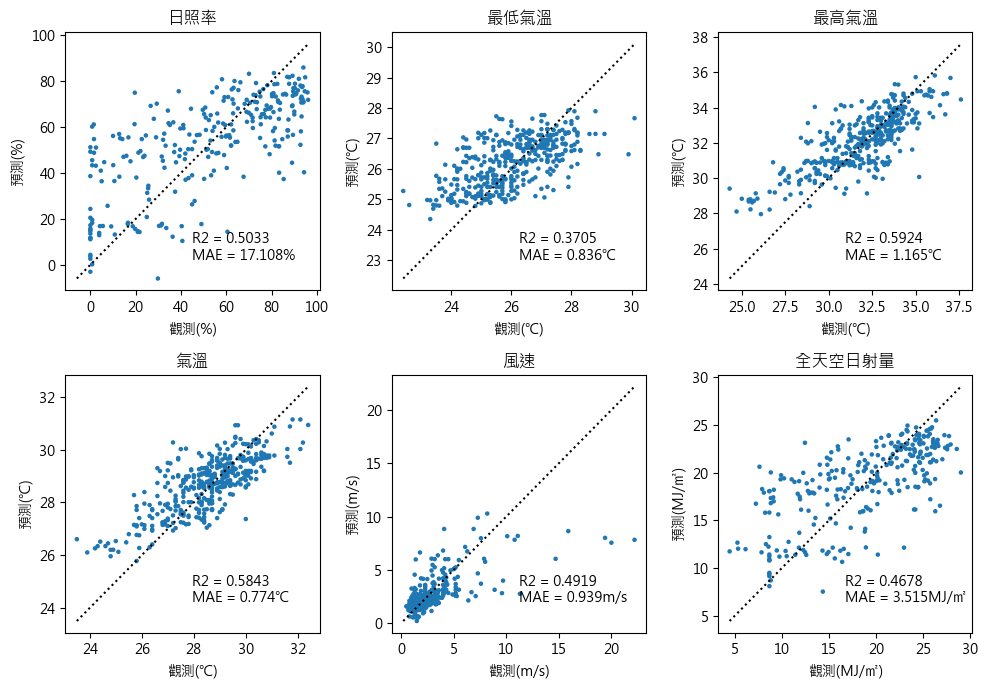

In [12]:
features = ['日照率', '最低氣溫', '最高氣溫', '氣溫', '風速', '全天空日射量']
fig, axes = plt.subplots(2, 3)
fig.set_size_inches([10,7])
for i, f in enumerate(features):
    this_ax = axes[int(i/3)][i%3]
    plot_one_axis(this_ax, w_pred_obs_df, f)
fig.tight_layout()

### 氣象署預報 VS 實際觀測

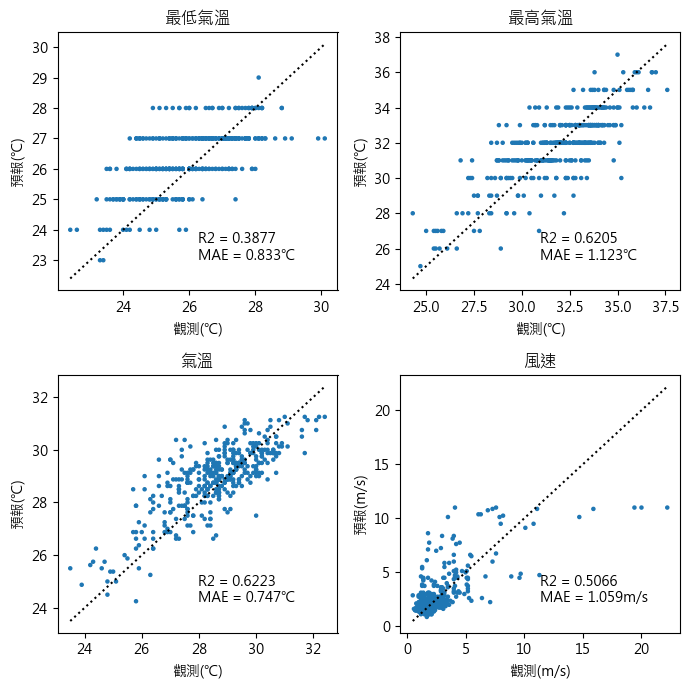

In [13]:
features = ['最低氣溫', '最高氣溫', '氣溫', '風速']
fig, axes = plt.subplots(2, 2)
fig.set_size_inches([7, 7])
for i, f in enumerate(features):
    this_ax = axes[int(i/2)][i%2]
    plot_one_axis(this_ax, w_forecast_obs_df, f, suffixes=['觀測', '預報'])
fig.tight_layout()